<a href="https://colab.research.google.com/github/jmaydwell1/Tensorflow-Deep-Learning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-Tuning
In the previous notebook, we've covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.

In [ ]:
# Check if we're usign a GPU
!nvidia-smi

Fri Aug 26 00:58:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions
In previous notebooks. we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

We've done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-26 00:58:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-26 00:58:49 (109 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

**Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_fuctions.py`, so you'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food). 

In [ ]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-08-26 00:58:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.128, 108.177.120.128, 142.250.159.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   159MB/s    in 1.0s    

2022-08-26 00:58:53 (159 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 750 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.93112244e+02 8.06989822e+01 1.26010201e+02]
   [1.94760193e+02 8.49489822e+01 1.29025513e+02]
   [1.89637756e+02 8.43571396e+01 1.24862244e+02]
   ...
   [1.81387756e+02 7.87449570e+01 1.16948990e+02]
   [1.82265335e+02 8.03163605e+01 1.17290840e+02]
   [1.80749802e+02 8.18212357e+01 1.15923256e+02]]

  [[1.88908157e+02 8.27193909e+01 1.23168365e+02]
   [1.91846939e+02 8.57908173e+01 1.25775513e+02]
   [1.93000000e+02 8.67857132e+01 1.24857140e+02]
   ...
   [1.83688904e+02 7.92195129e+01 1.19132774e+02]
   [1.80709183e+02 8.12041168e+01 1.18994896e+02]
   [1.82357040e+02 8.79744186e+01 1.21994820e+02]]

  [[1.86423462e+02 8.47806091e+01 1.17852036e+02]
   [1.92387756e+02 8.65306168e+01 1.22887756e+02]
   [1.95954086e+02 8.74030609e+01 1.24214287e+02]
   ...
   [1.74377655e+02 8.75255127e+01 1.26142899e+02]
   [1.77826538e+02 8.65714417e+01 1.24428558e+02]
   [1.74872269e+02 8.46579742e+01 1.20009972e+02]]

  ...

  [[2.06923462e+02 2.29923462e+02 2.43923462e+02]
   [2

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns are't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2 you iwll need to normalize inputs (you dont't have to for EfficientNet(s))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. combine the inpouts with te outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile for the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback("transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])


16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220826-005901
Epoch 1/5
24/24 [==============================] - 21s 210ms/step - loss: 1.8807 - accuracy: 0.3933 - val_loss: 1.3517 - val_accuracy: 0.6927
Epoch 2/5
24/24 [==============================] - 3s 130ms/step - loss: 1.1320 - accuracy: 0.7387 - val_loss: 0.9169 - val_accuracy: 0.8073
Epoch 3/5
24/24 [==============================] - 3s 114ms/step - loss: 0.8416 - accuracy: 0.8107 - val_loss: 0.7640 - val_accuracy: 0.8177
Epoch 4/5
24/24 [==============================] - 4s 132ms/step - loss: 0.6925 - accuracy: 0.8347 - val_loss: 0.5952 - val_accuracy: 0.8646
Epoch 5/5
24/24 [==============================] - 4s 134ms/step - loss: 0.5879 - accuracy: 0.8653 - val_loss: 0.4982 - val_accuracy: 0.8958


In [ ]:
# Evaluate on the full tes dataset
model_0.evaluate(test_data)

24/24 [==============================] - 2s 73ms/step - loss: 0.5139 - accuracy: 0.8947


[0.513917863368988, 0.8946666717529297]

In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [ ]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


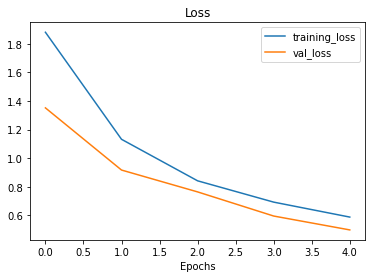

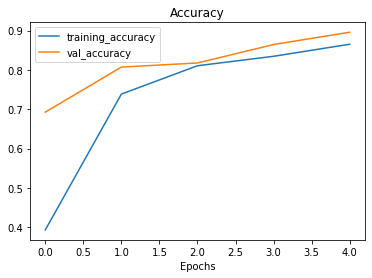

In [ ]:
# Check otu our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Poolong 2D layer...

We have a tensor after our model goes through `base_model` of shape(None,7,7,1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None,1280).

Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D.

In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: \n {input_tensor}")

# Pass the ranodm tenso through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor) 
print(f"2D global average pooled ranodm tensor: \n {global_average_pooled_tensor}\n")

# Check the shape of the diffeerent tensors
print(f"Shaep of inpout tnesor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
2D global average pooled ranodm tensor: 
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shaep of inpout tnesor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [ ]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

**Note:** One of the reasons feature extraction transfer learning is named how it is because what oftern happens is pretrained model outputs a **feature vector**, a long tensor of numbers which represents the learned represention of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract patterns out of or our own specific problem.

## Running a series of transfer learning experiments 

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data iwth data aumentation
4. `model_4` - use fine-tuning transfer learning 100% of the trainng data  with data augmentation

**Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

## Getting and preprocessing data for model_1

In [ ]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2022-08-26 00:59:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 142.250.128.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  76.6MB/s    in 1.7s    

2022-08-26 00:59:48 (76.6 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
# How many images are wek working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There a

In [ ]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) 
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentaiton right into our models, we can use the layers inside:

  * `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow Data augmentation documentation. 

Off the top of our heads, after reading the docs, the benefits of using data augmentaiton inside the model are:
  * Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU
  * lamge data augmentation only happens during training, so we can still export our whole model and use it elsewhere

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation statge with horizontal flipping, rotation, zooms, etc
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocesing.Rescale(1./255) # keeep for models like ResNet50V2 but EfficientNet10
])


### Visualize oru data augmentation layer (and see what hapens to our data)

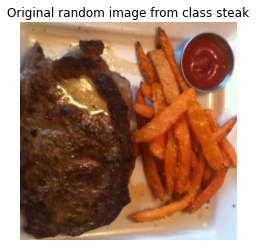

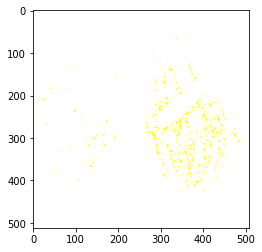

In [ ]:
# View a random image and compare it ot its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

# Now let's plot our augmented random image
augmented_img = data_augmentation(img)
plt.figure()
plt.imshow(augmented_img)

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't traiin it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D()(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220826-005952
Epoch 1/5


3/3 [==============================] - ETA: 0s - loss: 2.4403 - accuracy: 0.0571

3/3 [==============================] - 11s 2s/step - loss: 2.4403 - accuracy: 0.0571 - val_loss: 2.2241 - val_accuracy: 0.1694
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1576 - accuracy: 0.2571 - val_loss: 2.1151 - val_accuracy: 0.2401
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9612 - accuracy: 0.4571 - val_loss: 1.9897 - val_accuracy: 0.3306
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.8654 - accuracy: 0.4286 - val_loss: 1.9190 - val_accuracy: 0.3766
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6391 - accuracy: 0.6000 - val_loss: 1.8274 - val_accuracy: 0.4276


In [ ]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 7s 77ms/step - loss: 1.8215 - accuracy: 0.4384


[1.8215062618255615, 0.438400000333786]

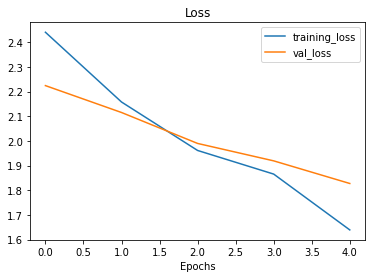

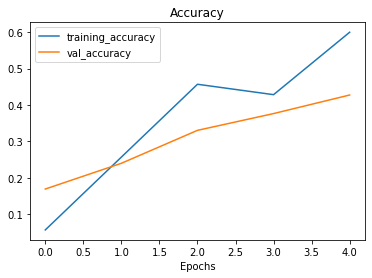

In [ ]:
# How do the model with 1% of the and data augmentation loss curves look?
plot_loss_curves(history_1_percent)

### Model 2: feature extraction transfer learning model with 10% of dat aand dat augmentation

In [ ]:
# Get 10%  of data...
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data(10_food_classes_percent)

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"


In [ ]:
# How many images are in our directories?
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

Found 2500 files belonging to 10 classes.


In [ ]:
# Create model 2 with dta augmentation built in 
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),

], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


# Creating a ModelCheckpoint call

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [ ]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)


### Fit model 2 passing in the ModelCheckpoint callback

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220826-010035
Epoch 1/5
79/79 [==============================] - ETA: 0s - loss: 1.4266 - accuracy: 0.5784
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
79/79 [==============================] - 37s 384ms/step - loss: 1.4266 - accuracy: 0.5784 - val_loss: 0.7340 - val_accuracy: 0.8092
Epoch 2/5
79/79 [==============================] - ETA: 0s - loss: 0.7643 - accuracy: 0.7920
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
79/79 [==============================] - 24s 297ms/step - loss: 0.7643 - accuracy: 0.7920 - val_loss: 0.5133 - val_accuracy: 0.8618
Epoch 3/5
79/79 [==============================] - ETA: 0s - loss: 0.6278 - accuracy: 0.8220
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
79/79 [==============================] - 22s 270ms/step - loss: 0.6278 - accuracy: 0.8220 - val_loss: 0.4549 - val_accuracy: 0.8684
E

In [ ]:
# what were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 7s 74ms/step - loss: 0.6119 - accuracy: 0.8380


[0.6118646264076233, 0.8379999995231628]

In [ ]:
# Check model_2 results on all test_data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 73ms/step - loss: 0.3673 - accuracy: 0.8904


[0.36729246377944946, 0.8903999924659729]

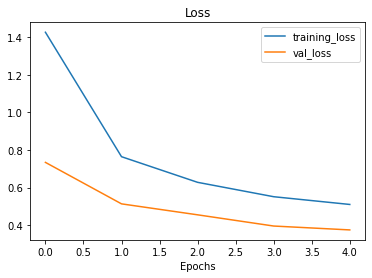

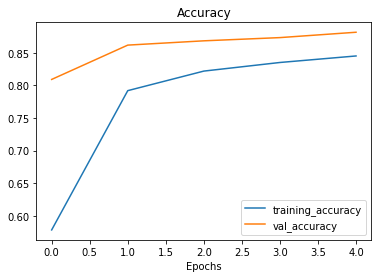

In [ ]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights
Loading in the checkpointed weights returns a specific checkpoint.

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.3673 - accuracy: 0.8904


In [ ]:
# If the results from our previously evaluated model_2 match the laoded weights, everything has worked!
results_10_percent_data_aug == loaded_weights_model_results

False

In [ ]:
results_10_percent_data_aug

[0.36729246377944946, 0.8903999924659729]

In [ ]:
loaded_weights_model_results

[0.3672923445701599, 0.8903999924659729]

In [ ]:
# Check to see if loaded model results are very clsoe to our previous non-loaded model
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[1.1920929e-07 0.0000000e+00]


### Model 3: Fine-tuning an existing model on 10% of the data

**Note:** Fine-tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data

In [ ]:
# Layers in loaded model
model_2.layers

In [ ]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fc289aa9b50> True
<keras.engine.sequential.Sequential object at 0x7fc289aa9810> True
<keras.engine.functional.Functional object at 0x7fc289610fd0> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fc289b19790> True
<keras.layers.core.dense.Dense object at 0x7fc3944fc050> True


In [ ]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# How many trainable variables are in our abase model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# To begin fine-tuning, let's start by setting the last 10 layes of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [ ]:
for layer in base_model.layers[:-10]:
  print(layer.name)

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])

input_3
rescaling_3
normalization_2
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
block3a_expand_conv
block3a_expand_bn
block3a_expand_activation
block3a_dwconv_pad
block3a_dwconv
block3a_bn
block3a_activation
block3a_se_squeeze
block3a_se_reshape
block3a_se_reduce
block3a_se_expand
block3a_se_

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


**Note:** When using fine-tuning it's best practice to lower your leaning rate by some amount. How much? This is a hyperparameter you can turne. But a good rule of thumb is at least 10X (though different sources will claim other values).

In [ ]:
# check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)


0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [ ]:
# Fine tuen for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1],
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220826-010314
Epoch 5/10
79/79 [==============================] - 30s 287ms/step - loss: 0.4391 - accuracy: 0.8568 - val_loss: 0.2880 - val_accuracy: 0.8980
Epoch 6/10
79/79 [==============================] - 19s 243ms/step - loss: 0.3915 - accuracy: 0.8636 - val_loss: 0.2493 - val_accuracy: 0.9046
Epoch 7/10
79/79 [==============================] - 17s 209ms/step - loss: 0.3465 - accuracy: 0.8840 - val_loss: 0.2343 - val_accuracy: 0.9211
Epoch 8/10
79/79 [==============================] - 21s 260ms/step - loss: 0.3105 - accuracy: 0.8964 - val_loss: 0.2082 - val_accuracy: 0.9293
Epoch 9/10
79/79 [==============================] - 17s 213ms/step - loss: 0.2960 - accuracy: 0.8964 - val_loss: 0.1871 - val_accuracy: 0.9408
Epoch 10/10
79/79 [==============================] - 20s 239ms/step - loss: 0.2655 - accuracy: 0.9188 - val_loss: 0.1969 - val_accuracy: 0.9359


In [ ]:
# Evaluate the fine-tuned model(model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.1907 - accuracy: 0.9360


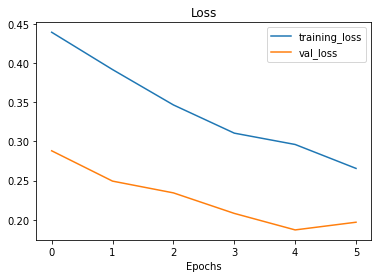

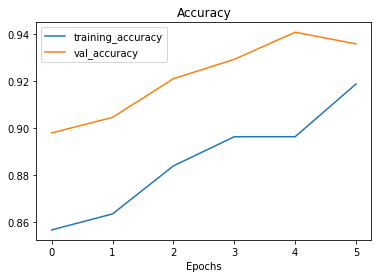

In [ ]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning).

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.5784000158309937, 0.7919999957084656, 0.8220000267028809, 0.8352000117301941, 0.8452000021934509, 0.8568000197410583, 0.8636000156402588, 0.8840000033378601, 0.896399974822998, 0.896399974822998, 0.9187999963760376]


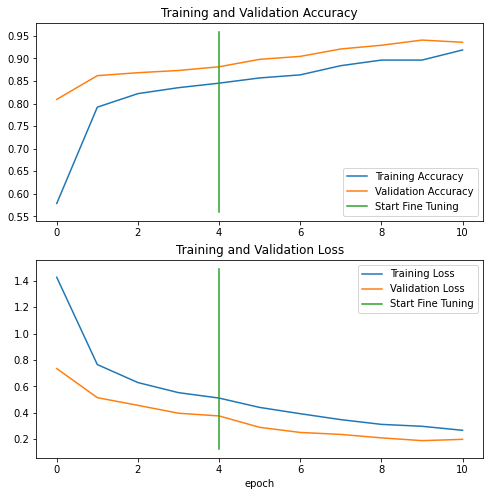

In [ ]:
compare_historys(original_history=history_10_percent_data_aug, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

## Model 4: Fine-tuning and existing model on all of the data

In [ ]:
# Download and unzip 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-08-26 01:05:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.128, 142.250.125.128, 142.250.136.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   227MB/s    in 2.2s    

2022-08-26 01:05:31 (227 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Evaluate model (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.1907 - accuracy: 0.9360


[0.19073139131069183, 0.9359999895095825]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights.

In [ ]:
# Load Weights from chekcpoint, that way we can fien-tune from
# the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [ ]:
# Let's eevaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 7s 76ms/step - loss: 0.3673 - accuracy: 0.8904


[0.3672923743724823, 0.8903999924659729]

In [ ]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.36729246377944946, 0.8903999924659729]

Alright, the previous steps might seem quite confusing buta ll we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on hte same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3)
2. Saved the results and training logs each time.
4. Reloaded the model from  step 1 to do the same steps as step 2 except this time we'ge going to use all of the data (model_4)

In [ ]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [ ]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7fc289aa9ad0> False
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fc289afc910> False
2 <keras.layers.preprocessing.normalization.Normalization object at 0x7fc289aa1090> False
3 <keras.layers.convolutional.ZeroPadding2D object at 0x7fc289aa9e50> False
4 <keras.layers.convolutional.Conv2D object at 0x7fc289ac01d0> False
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc289abab10> False
6 <keras.layers.core.activation.Activation object at 0x7fc289ac7a50> False
7 <keras.layers.convolutional.DepthwiseConv2D object at 0x7fc289a36310> False
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc289a3c190> False
9 <keras.layers.core.activation.Activation object at 0x7fc289ad9f50> False
10 <keras.layers.pooling.GlobalAveragePooling2D object at 0x7fc289a407d0> False
11 <keras.layers.core.reshape.Reshape object at 0x7fc289a51610> False
12 <keras.layers.convo